# biochempy tutorial

This notebook demonstrate how to use biochempy.

In [1]:
%load_ext autoreload
%autoreload 2

from biochempy.plotting import *
from biochempy.optimize import *
from biochempy.model import *
from biochempy.function import *
from biochempy.equations import *
from biochempy.data import *

%matplotlib inline
import matplotlib.pyplot as plt
import corner
from lmfit import printfuncs,fit_report
from tabulate import tabulate
from copy import deepcopy

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
model=Model()
function_factory=FunctionFactory()

In [540]:
experiment_name="PArB_CTP_ATP"

filedescr=[{'filename':"../ParB_CTP.ods",'sheet':"Sheet1",'cols':[0,1,2,3],'header':['t','bound','bound_err','protocol'],'delimiter':';','skiplines':1}
          ]

"parb_apo' = parb_ctp*koff_ctp + parb_cdp*koff_cdp + parb_apo_s*kunb_apo_s + parb_apo_x*kunb_apo_x - parb_apo*kon_ctp*ctp - parb_apo*kon_cdp*cdp - parb_apo*kbin_apo_s*s - parb_apo*kbin_apo_x*x"
"parb_ctp' = parb_apo*kon_ctp*ctp + parb_cdp*kxs_ctp + parb_ctp_s*kunb_ctp_s + parb_ctp_x*kunb_ctp_x - parb_ctp*koff_ctp - parb_ctp*kxh_ctp - parb_ctp*kbin_ctp_s*s - parb_ctp*kbin_ctp_x*x"
"parb_cdp' = parb_apo*kon_cdp*cdp + parb_ctp*kxh_ctp + parb_cdp_s*kunb_cdp_s + parb_cdp_x*kunb_cdp_x - parb_cdp*koff_cdp - parb_cdp*kxh_cdp - parb_cdp*kbin_cdp_s*s - parb_cdp*kbin_cdp_x*x"

"parb_apo_s' = parb_ctp_s*koff_ctp_s + parb_cdp_s*koff_cdp_s + parb_apo*kbin_apo_s*s + parb_apo_x*kjump_apo_xtos - parb_apo_s*kon_ctp_s*ctp - parb_apo_s*kon_cdp_s*cdp - parb_apo_s*kunb_apo_s - parb_apo_s*kjump_apo_stox"
"parb_ctp_s' = parb_apo_s*kon_ctp_s*ctp + parb_cdp_s*kxs_ctp_s + parb_ctp*kbin_ctp_s*s + parb_ctp_x*kjump_ctp_xtos - parb_ctp_s*koff_ctp_s - parb_ctp_s*kxh_ctp_s - parb_ctp_s*kunb_ctp_s - parb_ctp_s*kjump_ctp_stox"
"parb_cdp_s' = parb_apo_s*kon_cdp_s*cdp + parb_ctp_s*kxh_ctp_s + parb_cdp*kbin_cdp_s*s + parb_cdp_x*kjump_cdp_xtos - parb_cdp_s*koff_cdp_s - parb_cdp_s*kxs_ctp_s - parb_cdp_s*kunb_cdp_s - parb_cdp_s*kjump_cdp_stox"

"parb_apo_x' = parb_ctp_x*koff_ctp_x + parb_cdp_x*koff_cdp_x + parb_apo*kbin_apo_x*x + parb_apo_s*kjump_apo_stox - parb_apo_x*kon_ctp_x*ctp - parb_apo_x*kon_cdp_x*cdp - parb_apo_x*kunb_apo_x - parb_apo_x*kjump_apo_xtos"
"parb_ctp_x' = parb_apo_x*kon_ctp_x*ctp + parb_cdp_x*kxs_ctp_x + parb_ctp*kbin_ctp_x*x + parb_ctp_s*kjump_ctp_stox - parb_ctp_x*koff_ctp_x - parb_ctp_x*kxh_ctp_x - parb_ctp_x*kunb_ctp_x - parb_ctp_x*kjump_ctp_xtos"
"parb_cdp_x' = parb_apo_x*kon_cdp_x*cdp + parb_ctp_x*kxh_ctp_x + parb_cdp*kbin_cdp_x*x + parb_cdp_s*kjump_cdp_stox - parb_cdp_x*koff_cdp_x - parb_cdp_x*kxs_ctp_x - parb_cdp_x*kunb_cdp_x - parb_cdp_x*kjump_cdp_xtos"


# definitions
"s=Stot-parb_apo_s-parb_ctp_s-parb_cdp_s"
"x=Xtot-parb_apo_x-parb_ctp_x-parb_cdp_x"

# exchange rates
"kxh_ctp = kh_ctp + koff_ctp*kon_cdp/(kon_cdp*cdp+kon_ctp*alpha)"
"kxh_ctp_s = kh_ctp_s + koff_ctp_s*kon_cdp_s/(kon_cdp_s+kon_ctp_s*alpha)"
"kxh_ctp_x = kh_ctp_x + koff_ctp_x*kon_cdp_x/(kon_cdp_x+kon_ctp_x*alpha)"

# equilibrium constraints
"kxs_ctp = ks_ctp + ks_ctp/kh_ctp*koff_ctp*kon_cdp/(kon_cdp*cdp+kon_ctp*alpha)"
"kxs_ctp_s = ks_ctp_s + ks_ctp_s/kh_ctp_s*koff_ctp_s*kon_cdp_s/(kon_cdp_s+kon_ctp_s*alpha)"
"kxs_ctp_x = ks_ctp_x + ks_ctp_x/kh_ctp_x*koff_ctp_x*kon_cdp_x/(kon_cdp_x+kon_ctp_x*alpha)"


equations={'njct': ["fParbC' = fParb*CTP*kctp - fParbC*kmctp + bParbC*kmCDNA - fParbC*DNA*kCDNA",
                    "fParbA' = fParb*ATP*katp - fParbA*kmatp + bParbA*kmADNA - fParbA*DNA*kADNA",
                    "fParb' = -fParb*CTP*kctp - fParb*ATP*katp + fParbC*kmctp + fParbC*kmctp",
                    "bParbC'= -bParbC*kmCDNA + fParbC*DNA*kCDNA",
                    "bParbA'= -bParbA*kmADNA + fParbA*DNA*kADNA",
                    "fParb_0 = Ctot/(1+kctp*CTP/kmctp+katp*CTP/kmatp)",
                    "fParbC_0 = kctp*CTP/kmctp*Ctot/(1+kctp*CTP/kmctp+katp*CTP/kmatp)",
                    "fParbA_0 = katp*ATP/kmatp*Ctot/(1+kctp*CTP/kmctp+katp*CTP/kmatp)"
                   ],
           'wash': ["fParbC' = fParb*CTP*kctp - fParbC*kmctp + bParbC*kmCDNA - fParbC*DNA*kCDNA",
                    "fParbA' = fParb*ATP*katp - fParbA*kmatp + bParbA*kmADNA - fParbA*DNA*kADNA",
                    "fParb' = -fParb*CTP*kctp - fParb*ATP*katp + fParbC*kmctp + fParbC*kmctp",
                    "bParbC'= -bParbC*kmCDNA + fParbC*DNA*kCDNA",
                    "bParbA'= -bParbA*kmADNA + fParbA*DNA*kADNA",
                   ],
          }

constraints={'njct':["ATP=0.1","CTP=1.","DNA=DNA_0-bound","bound = bParbA + bParbC",],
             'wash':["ATP=0.1","CTP=0.1", "DNA=DNA_0-bound","bound = bParbA + bParbC","fParb_0 = 0","fParbC_0 = 0","fParbA_0 = 0"]
            }

observables=['bound']

display_report=True
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )


equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
if type(constraints)==list:
    constraints=[Equation(s) for s in constraints]
    equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}
elif type(constraints)==dict:
    constraints={k:[Equation(s) for s in eqs ] for k,eqs in constraints.items()}
    equations = {k:applyConstraints(eqs,constraints[k]) for k,eqs in equations.items()}
    
ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

model.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['bound'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['t', 'kmCDNA', 'kmADNA', 'kctp', 'kADNA', 'Ctot', 'kmatp', 'katp', 'kmctp', 'kCDNA']
['t', 'kmCDNA', 'bParbA_0', 'kmADNA', 'DNA_0', 'kctp', 'kADNA', 'Ctot', 'bParbC_0', 'kmatp', 'katp', 'kmctp', 'kCDNA']



# Report for experiment '**PArB_CTP_ATP**'

Your experiment is composed of **2** phases: **njct**, **wash**

Equations for phase **njct**:

	fParb_0 = Ctot/(1.0*katp/kmatp + 1.0*kctp/kmctp + 1)
	fParbC_0 = 1.0*Ctot*kctp/(kmctp*(1.0*katp/kmatp + 1.0*kctp/kmctp + 1))
	fParbA_0 = 0.1*Ctot*katp/(kmatp*(1.0*katp/kmatp + 1.0*kctp/kmctp + 1))
	ATP = 0.100000000000000
	CTP = 1.00000000000000
	DNA = DNA_0 - bound
	bound = bParbA + bParbC



Equations for phase **wash**:

	ATP = 0.100000000000000
	CTP = 0.100000000000000
	DNA = DNA_0 - bound
	bound = bParbA + bParbC
	fParb_0 = 0
	fParbC_0 = 0
	fParbA_0 = 0



In order to compute the required observables ['**bound**'] I will procede by steps:

+ Steps for phase **njct**:

{'t', 'kmCDNA', 'bParbA_0', 'kmADNA', 'DNA_0', 'kctp', 'kADNA', 'Ctot', 'bParbC_0', 'kmatp', 'katp', 'kmctp', 'kCDNA'} -> ['fParb_0'],['fParbC_0'],['fParbA_0'] -> ['fParbC', 'fParbA', 'fParb', 'bParbC', 'bParbA'] -> ['bound']


+ Steps for phase **wash**:

{'t', 'kmCDNA', 'bParbA_0', 'kmADNA', 'DNA_0', 'kctp', 'kADNA', 'bParbC_0', 'kmatp', 'katp', 'kmctp', 'kCDNA'} -> ['fParbC', 'fParbA', 'fParb', 'bParbC', 'bParbA'] -> ['bound']


You provided **1 replicate** for this experiment

## Providing initial data
 information about experiment data. Data can be initialized passing the following quantities:
After your model if populated with all your data and descriptions, it is time to provide some values for all model parameters.

`Data` is a class that stores
+ `value`: the value of that parameter.
+ `error`: the error associated with that value. Default is None.
+ `minv` : the minimumm possible value for that parameter. Default is 0.
+ `maxv` : the maximumm possible value for that parameter. Default is None.

During a fit, if a parameter is in the `variables` list, a gaussian prior will be used if an error is provided. Otherwise a flat prior will be used in the allowed region

In [541]:
init_data={
    'Ctot':Data(1000.,minv=0.),
    'kmCDNA':Data(0.1,minv=0.),
    'bParbA_0':Data(0.,minv=0.),
    'kmADNA':Data(0.1,minv=0.),
    'DNA_0':Data(10000.,minv=0.),
    'kADNA':Data(0.1,minv=0.),
    'bParbC_0':Data(0.,minv=0.),
    'kmatp':Data(0.1,minv=0.),
    'kmctp':Data(0.1,minv=0.),
    'kctp':Data(100,minv=0.),
    'katp':Data(0.1,minv=0.),
    'kCDNA':Data(1000.,minv=0.)
}

variables=['Ctot','kmCDNA','kmADNA','DNA_0','kADNA','kmatp','kmctp','kCDNA','kctp','katp']


## Fitting the model to data

The fitting procedure can be customized.
Here we show a simple example in which we fit the model by
+ run a first corse but robust optimization using the 'nelder' algorithm
+ refine the minimum by running a 'lbfgsb' minimization
+ running emcee to explore the parameter space around the minimum. This is useful in order to check 
the presence of multiple minima, determine the correlations between free parameters and estimate 
the errors on the fitted values

The following parameters customize this minimization protocol.

In [528]:
nsteps_nelder=1000
nsteps_lbfgsb=12000
nsamples_emcee=2000
burn_emcee=150
thin_emcee=1
nwalkers_emcee=50

### Run Nelder minimizer

In [536]:
opt=Optimize(model,init_data,variables)  
res_nelder=opt.minimize(maxiter=nsteps_nelder,replicas=1)
best_params=res_nelder.params

print("Optimized parameters:")
print(best_params.pretty_print())

KeyboardInterrupt: 

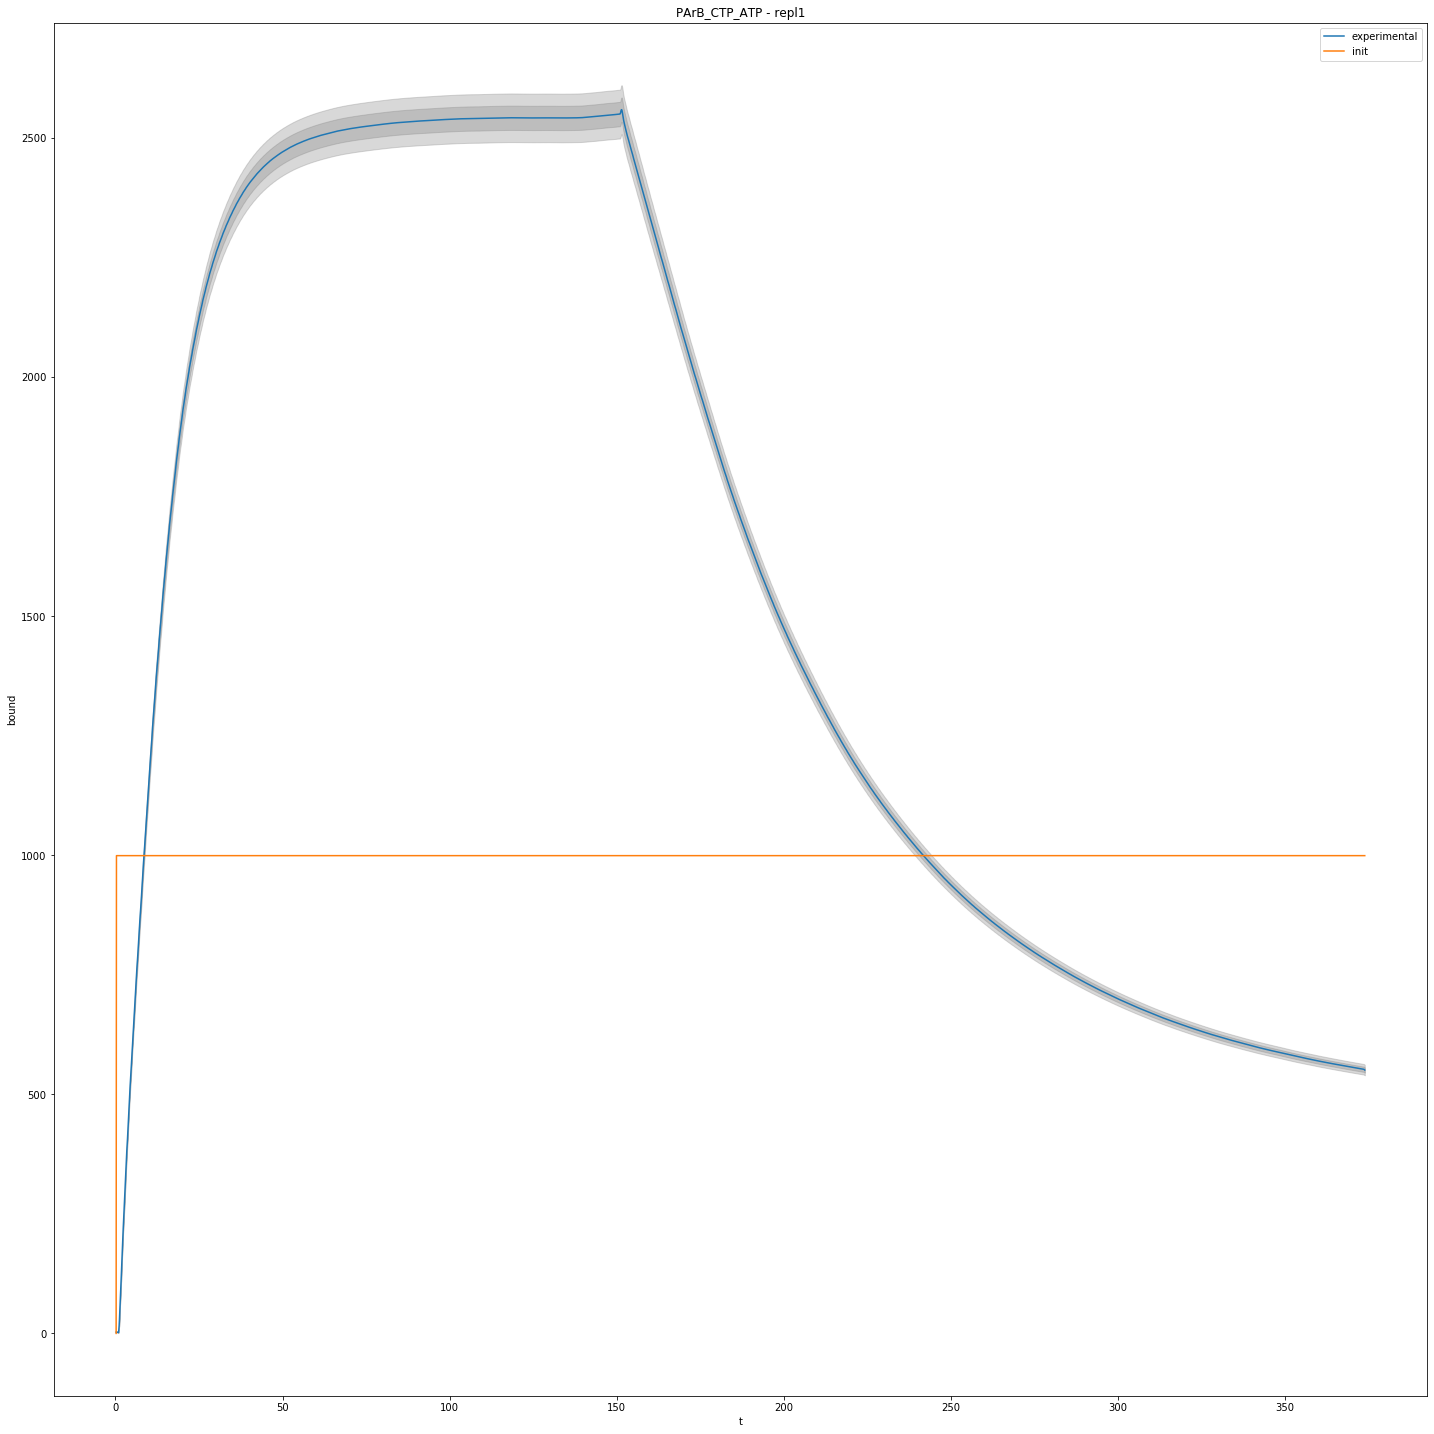

In [542]:
plotModel(model,params=[ (init_data,'init') ],plots=[ [('t','bound')] ])

### Run lbfgs-b minimizer

In [ ]:
res_lbfgsb=opt.minimize(method='lbfgsb',maxiter=nsteps_lbfgsb,params=best_params)
best_params=res_lbfgsb.params

print("Optimized parameters:")
print(best_params.pretty_print())

In [ ]:
plotModel(model,params=[ (best_params,'lbfgs-b') ],plots=[ [('t','bound')]])
plt.savefig("report_n1.png")

### Run emcee (can take ~1 h)

In [ ]:
res_emcee = opt.sampleMCMC(res_lbfgsb,workers=1,burn=burn_emcee,steps=nsamples_emcee,thin=thin_emcee,nwalkers=nwalkers_emcee)
emcee_plot = corner.corner(res_emcee[0], labels=res_emcee[1],truths=res_emcee[2])
data=[]
for i in range(len(res_emcee[1])):
    mcmc = np.percentile(res_emcee[0][:, i], [16, 50, 84])
    data.append( [res_emcee[1][i],mcmc[1],mcmc[0],mcmc[2]] )
print(tabulate(data, headers=['Name', 'Value', '16th perc.', '84th perc.']))

### Validation

Reproduce all your data by using random parameters sampled by emcee.

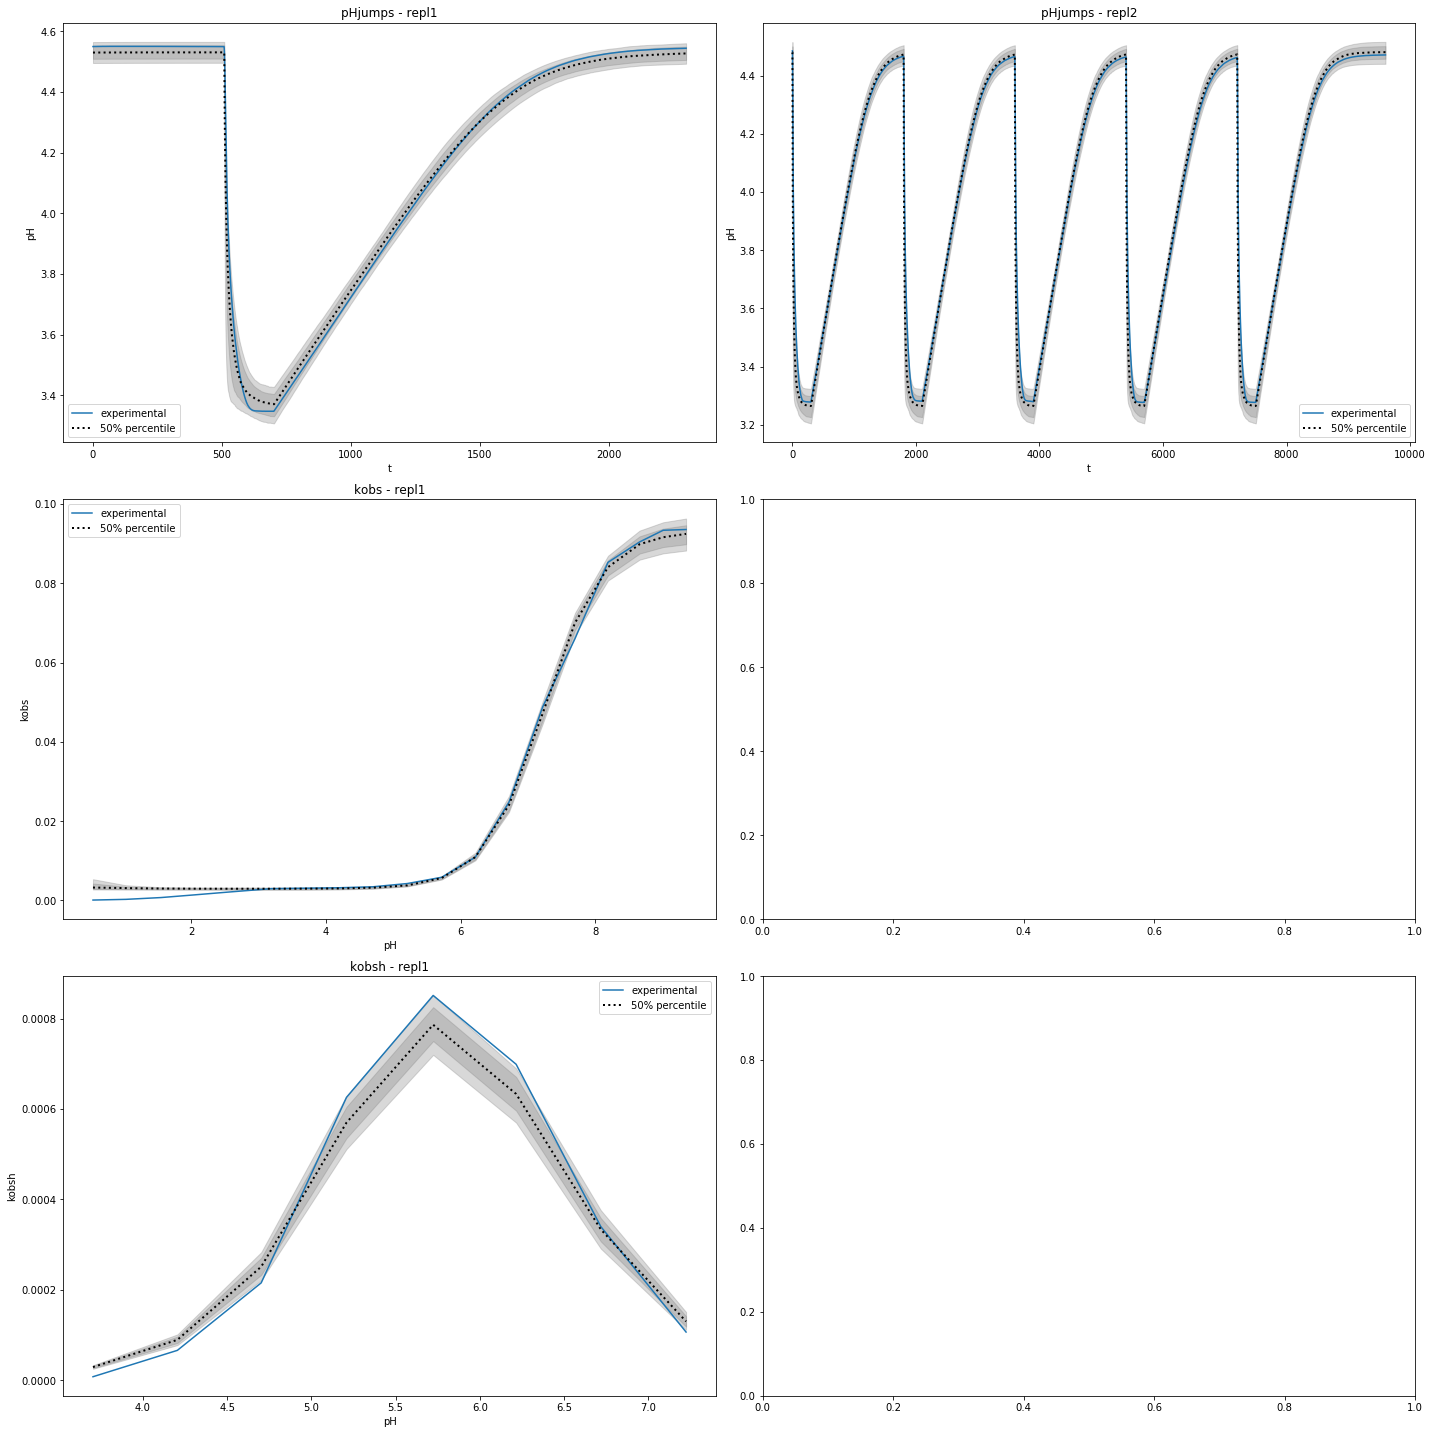

In [18]:
ncurves=1000
predictions_mcmc=[[{k:[] for k in repl.data.keys()} for repl in exp.replicates] for exp in model.experiments]
inds = np.random.randint(len(res_emcee[0]), size=ncurves)
params=[opt.listToParams(res_emcee[0][i]) for i in inds]

plotPredictionErrors(model,params=params,plots=[ [('t','pH')],[('pH','kobs')],[('pH','kobsh')] ],width=20,height=20,pad=1.0,fontsize=20)
